In [5]:
import random
from pymongo import MongoClient
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scripts import MONGO_URL, END_DATE
from scripts.analysis import data, plot

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
plot.init_matplotlib()

W, H = 6, 2.5

In [11]:
client = MongoClient(MONGO_URL)
db = client['fake_stars']
collection = db['fake_actor_events']

documents = list(collection.find({}))

df = pd.DataFrame(documents)

def compute_actor_features(df):
    # Group by actor and calculate total and activity-specific counts
    actor_group = df.groupby('actor').agg(
        total_activities=('type', 'count'),
        stars=('type', lambda x: (x == 'WatchEvent').sum()),
        issues=('type', lambda x: (x == 'IssuesEvent').sum()),
        prs=('type', lambda x: (x == 'PullRequestEvent').sum()),
        creates=('type', lambda x: (x == 'CreateEvent').sum()),
        forks=('type', lambda x: (x == 'ForkEvent').sum()),
        pushs=('type', lambda x: (x == 'PushEvent').sum()),
    ).reset_index()
    N = actor_group['total_activities']
    # Calculate the percentages of each activity type
    actor_group['star_ratio'] = actor_group['stars'] / N

    actor_group['issue_ratio'] = actor_group['issues'] / N

    actor_group['pr_ratio'] = actor_group['prs'] / N

    actor_group['create_ratio'] = actor_group['creates'] / N

    actor_group['fork_ratio'] = actor_group['forks'] / N

    actor_group['push_ratio'] = actor_group['pushs'] / N
    
    actor_group['other_ratio'] = 1- (actor_group['star_ratio'] + actor_group['issue_ratio']
                                     +actor_group['pr_ratio'] + actor_group['create_ratio']
                                     +actor_group['fork_ratio'] + actor_group['push_ratio'])
    actor_group.fillna(0, inplace=True)

    return actor_group


# Compute the features
actor_features = compute_actor_features(df)

features = actor_features[['star_ratio', 'issue_ratio', 'pr_ratio',
                           'create_ratio', 'fork_ratio', 'push_ratio', 'other_ratio']]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

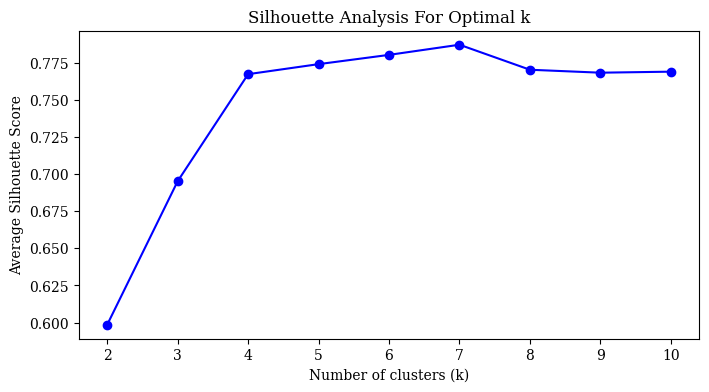

In [16]:
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.metrics import pairwise_distances
# Range of cluster numbers to try
k_values = range(2, 11)

# List to store the silhouette scores for each k
silhouette_scores = []

for k in k_values:
    kmeans_model = KMeans(n_clusters=k, random_state=42).fit(scaled_features)
    labels = kmeans_model.labels_
    silhouette_scores.append(metrics.silhouette_score(scaled_features, labels, metric='euclidean'))

# Plotting the results
plt.figure(figsize=(8, 4))
plt.plot(k_values, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Analysis For Optimal k')
plt.show()


In [18]:

kmeans = KMeans(n_clusters=4, random_state=42)
actor_features['cluster'] = kmeans.fit_predict(scaled_features)


ratio_columns = ['star_ratio', 'issue_ratio', 'pr_ratio', 'create_ratio', 'fork_ratio', 'push_ratio', 'other_ratio']

cluster_means = actor_features.groupby('cluster')[ratio_columns].mean()

print(cluster_means)

cluster_counts = actor_features.groupby(
    'cluster').size().reset_index(name='actor_count')
print(cluster_counts)


         star_ratio  issue_ratio  pr_ratio  create_ratio  fork_ratio  \
cluster                                                                
0          0.974540     0.001596  0.000602      0.006866    0.005625   
1          0.234895     0.098116  0.079561      0.075389    0.028796   
2          0.270507     0.011221  0.019677      0.196949    0.030544   
3          0.499812     0.001446  0.000465      0.008687    0.476205   

         push_ratio  other_ratio  
cluster                           
0          0.008008     0.002764  
1          0.264234     0.219009  
2          0.429630     0.041472  
3          0.011039     0.002347  
   cluster  actor_count
0        0         7653
1        1          516
2        2         1241
3        3          677


In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

unique_clusters = [0,1,2,3]
perplexities = [30, 50, 100]
tsne_df = {}
for p in perplexities:
    tsne = TSNE(n_components=2, perplexity=p, n_iter=1000, random_state=114514)
    tsne_results = tsne.fit_transform(scaled_features)

    tsne_df[p] = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
    tsne_df[p]['cluster'] = actor_features['cluster']

    


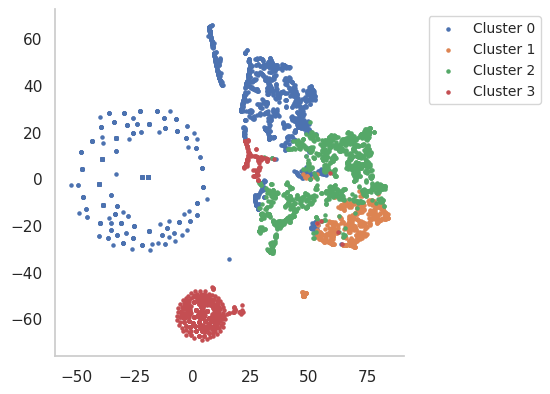

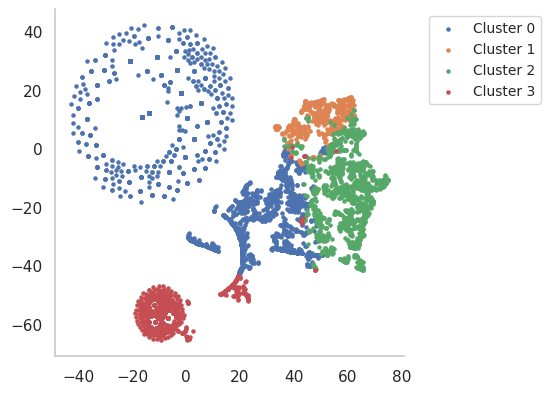

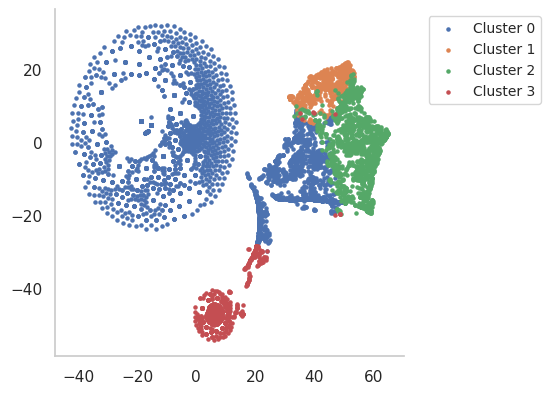

In [35]:

color_dict = {0: "C0", 1: "C1", 2: "C2", 3:"C3"}

for p in perplexities:
    fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))
    ax.grid(False)
    for cluster in unique_clusters:
        cluster_data = tsne_df[p][tsne_df[p]['cluster'] == cluster]
        
        ax.scatter(
            cluster_data['TSNE1'],
            cluster_data['TSNE2'],
            c=[color_dict[cluster]],    # Color assigned to this cluster
            label=f'Cluster {cluster}', # Label for the legend
            s=5,                       # Marker size; adjust as needed
            marker='o'
        )


    # Place the legend outside the plot area
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

    # Adjust layout to prevent clipping of legend
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Display the plot
    fig.savefig(f"plots/tsne-users-{p}.pdf", bbox_inches="tight", dpi=300)
